# Import Bibliotheken

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import requests

%matplotlib inline

# Funktionen aus Konrads Scribble

In [34]:
def runQuery(queryString):
    post_json = dict()
    post_json["query"] = queryString
    header = { 'Content-Type': 'application/json' }
    URL = "https://api-next.datengui.de/graphql"
    resp = requests.post(url=URL,headers=header,json=post_json)
    
    if resp.status_code == 200:
        return resp.json()
    else:
        raise Exception(f"Http error: status code {resp.status_code}")

In [35]:
# Query Transformation

def convertHirachy(hierachy):
    new_dic = dict()
    for key,value in hierachy.items():
        if type(value) == dict:
            new_dic[key] = convertHirachy(value)
        elif type(value) == list:
            new_dic[key] = pd.concat(list(map(convertHirachy,value)))
        else:
            new_dic[key] = value
            
    return dicToDf(new_dic)

def dicToDf(dic):
    n_df = countDataFrames(dic)
    if n_df == 0:
        return pd.DataFrame(dic,index=[0])
    else:
        df = findDataFrame(dic)
        return addDictScalarsToDf(dic,df)

def countDataFrames(dic):
    n_dfs = 0
    for value in dic.values():
        if type(value) == pd.DataFrame:
            n_dfs += 1
    return n_dfs
            
def findDataFrame(dic):
    for (key,value) in dic.items():
        if type(value) == pd.DataFrame:
            return value
        
def addDictScalarsToDf(dic,df):
    for (key,value) in dic.items():
        if type(value) != pd.DataFrame:
            df[key] = value
        else:
            df = df.rename(columns = {'value':key})
    return df

# Strings für Datenguide API
Abfrage der Werte für alle verfügbaren Jahre auf Bundeslandebene (NUTS 1).
- BEV001: Anzahl Geburten
- BEVSTD: Bevölkerungsstand

In [36]:
geburten = """
{
  allRegions(page: 0, itemsPerPage: 20) {
    regions (nuts: 1){
      id
      name
    BEV001 {
        value
        year
        }
    }
    page
    itemsPerPage
    total
    }
}  
"""

db_geburten = runQuery(geburten)

In [37]:
bevoelkerung = """
{
  allRegions(page: 0, itemsPerPage: 20) {
    regions (nuts: 1){
      id
      name
    BEVSTD {
        value
        year
        }
    }
    page
    itemsPerPage
    total
    }
}  
"""

db_bevoelkerung = runQuery(bevoelkerung)

# Abfrageergbnis in einen DataFrame umwandeln

In [38]:
df_geburten = convertHirachy(db_geburten)
df_bevoelkerung = convertHirachy(db_bevoelkerung)

# Datensätze zusammenführen
Datensätze mittels Jahr und Bundesland-ID zufammenführen, Geburtenrate als Anzahl der Lebendgeborenen pro Jahr bezogen auf 1000 Einwohner berechnen und das jeweilige Jahr in ein DateTime Objekt umwandeln. Für die Darstellung den DataFrame drehen, sodass jede Zeile einem Jahr entspricht.

In [70]:
# df zusammenführen
df=pd.merge(df_geburten, df_bevoelkerung, on=['id','year','name'])

# Berechnung Geburtenrate pro 1000 Eeinwohner
df['birth_rate_1000']=df['BEV001']/df['BEVSTD']*1000

# df anpassen
df = df[['year','name','birth_rate_1000']]
df['year'] = pd.to_datetime(df['year'], format='%Y')
df = df.pivot_table(index='year',columns='name',values='birth_rate_1000')  

# Darstellung

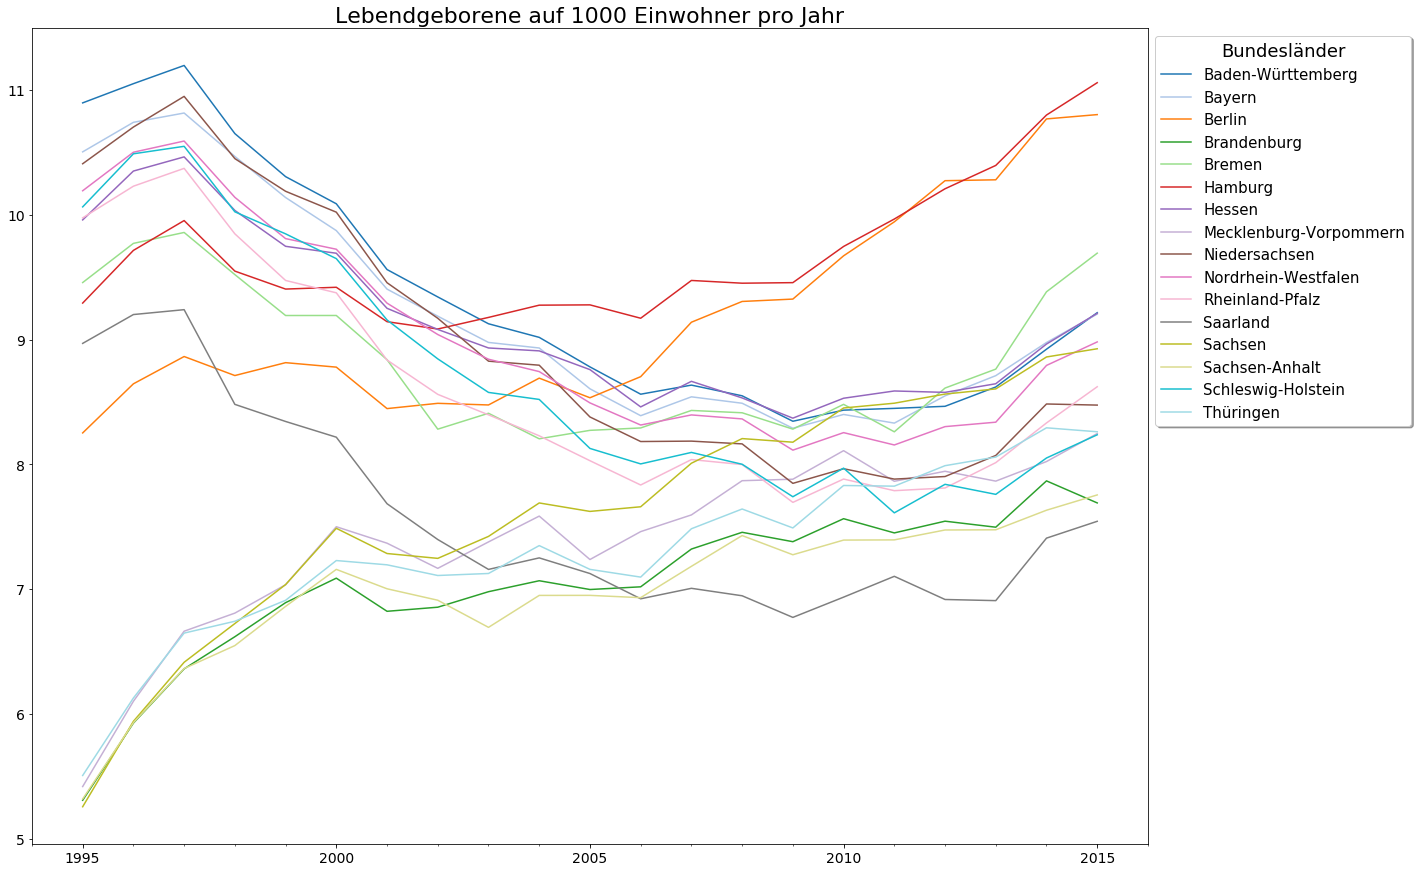

In [161]:
ax = df.plot(cmap='tab20', fontsize= 14, figsize=(20,15))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Bundesländer', title_fontsize=18, shadow='T', fancybox='T', prop={'size': 15})
ax.set_title('Lebendgeborene auf 1000 Einwohner pro Jahr',fontsize= 22)
ax.set_xlabel('')
output = plt.gcf()
output.savefig("use_case_geburten.jpg", bbox_inches='tight', pad_inches=0.5)